In [2]:
import torch.nn as nn 
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
%matplotlib inline

c:\Users\Antoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
words=open("names.txt").read().splitlines()

In [31]:
chars=sorted(list(set("".join(words))))
stoi={s: i+1 for i,s in enumerate(chars)}
stoi['.']=0


itos={i:s for s,i in stoi.items()}
encode= lambda s : [stoi[c] for c in s] #-->int
decode=lambda i :  "".join([itos[x] for x in i  ])




In [32]:

block_size=3
def build_dataset(words) :
    X,Y=[],[]

    for w in words:
        context=[0] * block_size
        for ch in w+ '.' :
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("".join([itos[i] for i in context])," gives ","".join(itos[ix]))
            context=context[1:]+ [ix]

    X=torch.tensor(X)
    Y=torch.tensor(Y)
    print(X.shape)
    return X,Y

import random 
random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr,Ytr=build_dataset(words[:n1])
Xdev,Ydev=build_dataset(words[n1:n2])
Xte,Yte=build_dataset(words[n2:])

torch.Size([182625, 3])
torch.Size([22655, 3])
torch.Size([22866, 3])


In [33]:
#Compare gradient
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [34]:
len(chars)

26

In [35]:
g=torch.Generator().manual_seed(2147483647)

vocab_size=27
n_emb=10
hidden_layer=n_hidden=200

C=torch.randn((vocab_size,n_emb))
W1=torch.randn((n_emb*block_size,hidden_layer),generator=g) * (5/3)/((n_emb*block_size)**0.5)#*0.2
b1=torch.randn(hidden_layer,generator=g)*0.1
W2=torch.randn((hidden_layer,vocab_size),generator=g)*0.1
b2=torch.randn(vocab_size,generator=g)*0.1

bngain=torch.randn(1,n_hidden)*0.1 + 1.0
bnbias=torch.randn(1,n_hidden)*.1
bnmean_running=torch.zeros(1,n_hidden)
bnstd_running=torch.ones(1,n_hidden)
parameters=[C,W1,b1,W2,b2,bngain,bnbias]

for p in parameters:
    p.requires_grad=True


In [36]:
lri=[]
lossi=[]
stepi=[]



In [37]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [69]:

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability so that exp() doesn't overflow
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.7593, grad_fn=<NegBackward0>)

In [39]:
hpreact.shape



torch.Size([32, 200])

In [70]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

# -----------------
# YOUR CODE HERE :)
# -----------------

Y=F.one_hot(Yb,num_classes=27)
dlogprobs=-Y/32
cmp('logprobs', dlogprobs, logprobs)

dprobs=dlogprobs*1/probs
cmp('probs', dprobs, probs)

dcounts_sum_inv=(dprobs*counts).sum(1,keepdim=True) 
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

dcounts_sum=dcounts_sum_inv*(-1/counts_sum**2)
cmp('counts_sum', dcounts_sum, counts_sum)


dcounts=torch.ones_like(counts)*dcounts_sum + dprobs*counts_sum_inv
cmp('counts', dcounts, counts)

dnorm_logits=counts*dcounts
cmp('norm_logits', dnorm_logits, norm_logits)

dlogit_maxes=(-dnorm_logits).sum(1,keepdim=True)
cmp('logit_maxes', dlogit_maxes, logit_maxes)

dlogits=F.one_hot(logits.max(1).indices,num_classes=logits.shape[1])*dlogit_maxes + dnorm_logits
cmp('logits', dlogits, logits)

dh=dlogits@W2.T
cmp('h', dh, h)

dW2=h.T@dlogits
cmp('W2', dW2, W2)

db2=dlogits.sum(0)
cmp('b2', db2, b2)

dhpreact=dh*(1-torch.tanh(hpreact)**2)
cmp('hpreact', dhpreact, hpreact)

dbngain=(dhpreact*bnraw).sum(0,keepdim=True)
cmp('bngain', dbngain, bngain)

dbnbias=dhpreact.sum(0,keepdim=True)
cmp('bnbias', dbnbias, bnbias)

dbnraw=dhpreact*bngain
cmp('bnraw', dbnraw, bnraw)

dbnvar_inv=(dbnraw*bndiff).sum(0,keepdim=True)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

dbnvar=(dbnvar_inv)*(-0.5*((bnvar+1e-5)**-1.5))
cmp('bnvar', dbnvar, bnvar)

dbndiff2= 1/(n-1) * torch.ones_like(bndiff2)*dbnvar
cmp('bndiff2', dbndiff2, bndiff2)

dbndiff=2*bndiff*dbndiff2 + bnvar_inv*dbnraw
cmp('bndiff', dbndiff, bndiff)

dbnmeani=(-1*dbndiff).sum(0)
cmp('bnmeani', dbnmeani, bnmeani)

dhprebn=dbndiff+ (1/n)*torch.ones_like(hprebn)*dbnmeani
cmp('hprebn', dhprebn, hprebn)

dembcat=dhprebn@W1.T
cmp('embcµat', dembcat, embcat)

dW1=embcat.T@dhprebn
cmp('W1', dW1, W1)

db1=dhprebn.sum(0)
cmp('b1', db1, b1)

demb=dembcat.view(emb.shape[0],emb.shape[1], emb.shape[2])
cmp('emb', demb, emb)


dC=torch.zeros_like(C)
for k in range(Xb.shape[0]) :
    for j in range(Xb.shape[1]) :
        ix=Xb[k,j]
        dC[ix]+=demb[k,j]


cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [41]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.7629151344299316 diff: 4.76837158203125e-07


In [42]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [48]:
torch.var

tensor([[ 3.6104e-04,  6.9559e-04,  9.1139e-04,  3.1884e-04,  7.5230e-04,
          8.5073e-04,  7.4304e-04, -2.9837e-02,  1.1258e-03,  1.9946e-03,
          6.2782e-04,  1.5654e-03,  1.8000e-04,  6.7390e-03,  4.5210e-04,
          2.0327e-03,  8.8493e-04,  1.8751e-03,  6.4239e-04,  3.0904e-04,
          3.4170e-04,  5.1870e-04,  1.9513e-03,  1.9469e-03,  5.2962e-04,
          4.0189e-04,  1.0853e-03],
        [ 9.5695e-04,  1.2250e-03,  7.2955e-04,  1.8292e-03,  1.0490e-03,
          6.1403e-04,  1.2267e-03,  2.0571e-03,  3.1434e-03,  2.4961e-04,
          7.5121e-04,  8.6155e-04,  3.8467e-03,  2.1346e-04,  1.1377e-03,
          2.2949e-03,  4.0153e-04,  1.7926e-03,  5.9910e-04,  2.7025e-04,
          4.9008e-04,  7.3389e-04, -3.0666e-02,  7.1439e-04,  8.2570e-04,
          1.2596e-03,  1.3925e-03],
        [ 9.2975e-04,  5.5157e-04,  5.6078e-04, -3.0073e-02,  6.1974e-04,
          7.7691e-04,  7.0684e-04,  1.3975e-03,  2.8441e-03,  3.9557e-04,
          6.7194e-04,  9.6842e-04,  6.92

In [65]:
# backward pass

dlogits=F.softmax(logits,1)
dlogits[range(n),Yb]-=1
dlogits/=n

cmp('logits',dlogits,logits)

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
dhprebn =-1*(bngain * bnvar_inv/n) * (n/(n-1)*bnraw*(dhpreact*bnraw).sum(0) - n*dhpreact + dhpreact.sum(0))

# -----------------
# dhprebn.shape
cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

logits          | exact: False | approximate: True  | maxdiff: 6.51925802230835e-09
hprebn          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09


In [72]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
#with torch.no_grad():

# kick off optimization
for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hprebn = embcat @ W1 + b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmean = hprebn.mean(0, keepdim=True)
  bnvar = hprebn.var(0, keepdim=True, unbiased=True)
  bnvar_inv = (bnvar + 1e-5)**-0.5
  bnraw = (hprebn - bnmean) * bnvar_inv
  hpreact = bngain * bnraw + bnbias
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  # loss.backward() # use this for correctness comparisons, delete it later!

  # manual backprop! #swole_doge_meme
  # -----------------
  # YOUR CODE HERE :)
  grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
  # -----------------

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p, grad in zip(parameters, grads):
    # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
    p.data += -lr * grad # new way of swole doge TODO: enable

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    break

12297
      0/ 200000: 3.7314


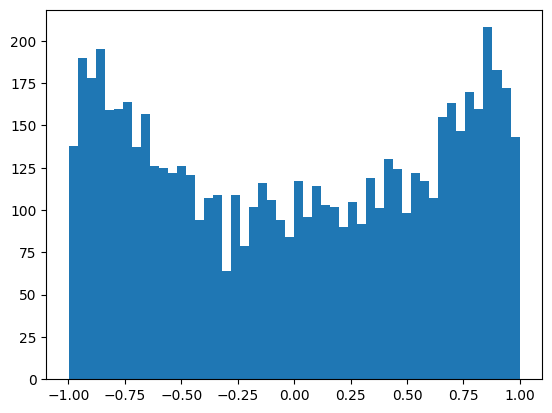

In [18]:
plt.hist(h.view(-1).tolist(),50);

In [ ]:
#calibrate the batch norm statistic

with torch.no_grad() :
    emb=C[Xtr]
    embcat=emb.view(emb.shape[0],-1)
    hpreact=embcat@W1 + b1
    #mesure the mean/std over the entre training set
    bnmean=hpreact.mean(0,keepdim=True)
    bnstd=hpreact.std(0,keepdim=True)


In [ ]:
@torch.no_grad() #disable gradient tracking
def split_loss(split):
    dict={'train' : (Xtr,Ytr),
         'val' : (Xdev,Ydev),
         'test':(Xte,Yte),}
    x,y=dict[split]
    emb=C[x]
    embcat=emb.view(emb.shape[0],-1)
    hpreact=embcat@W1 + b1
    hpreact=bngain*((hpreact-bnmean)/bnstd) + bnbias
    h=torch.tanh(hpreact) ##broadcasting
    logits=h@W2 +b2
    loss=F.cross_entropy(logits,y)
    print(split,loss.item())



In [ ]:
split_loss("val")

val 2.1870784759521484
